/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

Outputs for data_east/cases:
          system_cost           carbon system_capacity wave_capacity  \
0   2525826554.255996   7710200.568759    39476.979317  10027.483789   
1   2579141270.918525   7760179.966219      39492.1413   9920.079182   
2   2629893348.874698   8263769.770389    40134.334925   8818.509186   
3   2671991316.418417    8573938.73055    41091.675403   7309.332275   
4     2707914453.1505   8765110.509915    41962.095916   6244.270245   
5   2737974371.434411   9856050.250627    42282.559157   5256.040165   
6   2764521834.748593  10039300.604598    42729.979431   4792.129145   
7    2788950147.34185  10321152.154254    42900.982178   4435.936103   
8    2810048399.66872  11553233.107673     43268.24765   3350.009668   
9   2827147609.432484  11593717.194073     43825.04281    3074.97108   
10  2842877567.953012  11636212.403879    44379.287431   2822.018293   
11  2855851369.545053  11753764.815822    45520.990808   2053.741883   
12  2865996721.241401   11822366.56

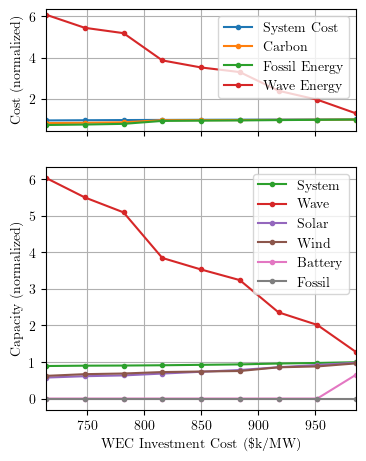

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

location = 'data_east'
inputs = pd.read_csv(os.path.join(location,'scenario_input.csv'))
all_loc_case_folders = [os.path.join(location,'cases')]
output_cols = ['system_cost', 'carbon', 'system_capacity','wave_capacity', 'solar_capacity', \
               'onshore_wind_capacity', 'offshore_wind_capacity', 'battery_capacity','fossil_capacity',
               'solar_costs', 'onshore_wind_costs', 'offshore_wind_costs',
               'battery_costs', 'fossil_costs','fossil_energy', 'wave_energy'] 
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)
output_scale = {'system_cost': 1e7, 'carbon': 1e4, 'system_capacity': 100, \
                'wave_capacity': 100, 'solar_capacity': 100, \
                'onshore_wind_capacity': 100, 'offshore_wind_capacity': 100, \
                'battery_capacity': 100, 'fossil_capacity': 100}

wave_name = 'wave'
solar_name = ['utilitypv','solar_photovoltaic']
onshore_wind_name = ['onshore_wind','landbasedwind']
offshore_wind_name = ['offshore_wind','offshorewind']
battery_name = ['battery','batteries']
fossil_name = ['coal','natural_gas','peaker','naturalgas']

plt.style.use("paper.mplstyle")

for this_loc_cases_folder in all_loc_case_folders:
    for case in np.arange(1,len(inputs)+1):
        idx = case - 1
        this_case_folder = os.path.join(this_loc_cases_folder,'Case_'+str(case))
        case_result_folder = os.path.join(this_case_folder,'results_2','results_p1')
        cost_file     = os.path.join(case_result_folder,'costs.csv')
        carbon_file   = os.path.join(case_result_folder,'emissions.csv')
        capacity_file = os.path.join(case_result_folder,'capacity.csv')
        energy_file   = os.path.join(case_result_folder,'capacityfactor.csv')

        system_cost_df   = pd.read_csv(cost_file,     index_col='Costs') # units: presumably dollars, need to double check
        carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3) # units: tonnes CO2
        capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap','NewCap']) # units: MW
        energy_df = pd.read_csv(energy_file, index_col='Resource', usecols=['Resource','AnnualSum']) # units: MWh

        system_cost = system_cost_df['Total'].loc['cTotal']
        carbon = carbon_df['Total'].loc['AnnualSum']
        system_capacity = capacity_df['EndCap'].loc['Total']
        
        wave_idx = capacity_df.index.str.contains(wave_name, regex=True)
        wave_capacity = capacity_df['NewCap'].loc[wave_idx].sum()
        pct_wave_capacity = wave_capacity / system_capacity

        solar_idx = capacity_df.index.str.contains('|'.join(solar_name), regex=True)
        solar_capacity = sum(capacity_df['NewCap'].loc[solar_idx])
        pct_solar_capacity = solar_capacity / system_capacity

        onshore_wind_idx = capacity_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
        onshore_wind_capacity = sum(capacity_df['NewCap'].loc[onshore_wind_idx])
        pct_onshore_wind_capacity = onshore_wind_capacity / system_capacity

        offshore_wind_idx = capacity_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
        offshore_wind_capacity = sum(capacity_df['NewCap'].loc[offshore_wind_idx])
        pct_offshore_wind_capacity = offshore_wind_capacity / system_capacity

        battery_idx = capacity_df.index.str.contains('|'.join(battery_name), regex=True)
        battery_capacity = sum(capacity_df['NewCap'].loc[battery_idx])
        pct_battery_capacity = battery_capacity / system_capacity

        fossil_idx = capacity_df.index.str.contains('|'.join(fossil_name), regex=True)
        fossil_capacity = sum(capacity_df['NewCap'].loc[fossil_idx])
        pct_fossil_capacity = fossil_capacity / system_capacity

        fossil_idx = energy_df.index.str.contains('|'.join(fossil_name), regex=True)
        fossil_energy = energy_df['AnnualSum'].loc[fossil_idx].sum()

        wave_idx = energy_df.index.str.contains(wave_name, regex=True)
        wave_energy = energy_df['AnnualSum'].loc[wave_idx].sum()

        # input costs for other resources
        input_folder = os.path.join(this_case_folder, 'inputs', 'inputs_p1')
        vre_file = os.path.join(input_folder, 'resources','Vre.csv')
        vre_df = pd.read_csv(vre_file, index_col='Resource',usecols=['Resource','capex_mw'])

        solar_idx = vre_df.index.str.contains('|'.join(solar_name), regex=True)
        solar_costs = np.unique(vre_df['capex_mw'].loc[solar_idx])

        onshore_wind_idx = vre_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
        onshore_wind_costs = np.unique(vre_df['capex_mw'].loc[onshore_wind_idx])

        offshore_wind_idx = vre_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
        offshore_wind_costs = np.unique(vre_df['capex_mw'].loc[offshore_wind_idx])

        battery_file = os.path.join(input_folder, 'resources', 'Storage.csv')
        battery_df = pd.read_csv(battery_file, index_col='Resource', usecols=['Resource', 'capex_mw'])
        battery_idx = battery_df.index.str.contains('|'.join(battery_name), regex=True)
        battery_costs = np.unique(battery_df['capex_mw'].loc[battery_idx])

        fossil_file = os.path.join(input_folder, 'resources', 'Thermal.csv')
        fossil_df = pd.read_csv(fossil_file, index_col='Resource', usecols=['Resource', 'capex_mw'])
        fossil_idx = fossil_df.index.str.contains('|'.join(fossil_name), regex=True)
        fossil_costs = np.unique(fossil_df['capex_mw'].loc[fossil_idx])

        outputs.loc[idx] = [system_cost, carbon, system_capacity,\
                            wave_capacity, solar_capacity, onshore_wind_capacity,\
                            offshore_wind_capacity, battery_capacity, fossil_capacity,
                            solar_costs, onshore_wind_costs, offshore_wind_costs,\
                            battery_costs, fossil_costs, fossil_energy, wave_energy]

    outputs.reset_index(drop=True, inplace=True)
    print(f"Outputs for {this_loc_cases_folder}:")
    print(outputs)

    # extract inputs
    wec_cost_str = inputs.wave_cost.values
    wec_cost = np.array([float(c.rsplit('_')[-1]) for c in wec_cost_str])
    print(f"Weccost: {wec_cost}")
    wave_variability = inputs.wave_variability.values
    power_lim = np.array([float(v.rsplit('_')[-1]) for v in wave_variability])
    omega_n   = np.array([float(v.rsplit('_')[-3]) for v in wave_variability])
    zeta      = np.array([float(v.rsplit('_')[2])  for v in wave_variability])

    # determine size for reshaping
    num_costs = len(np.unique(wec_cost))
    num_power_limits = len(np.unique(power_lim))
    size_tuple = (num_costs, num_power_limits)

    # reshape inputs for plotting
    wec_cost = np.reshape(wec_cost, size_tuple)
    power_lim = np.reshape(power_lim, size_tuple)
    # ignore omega_n and zeta for now, not used in plotting

    # hardcoded based on result - in the future do this programatically
    x = 250/8
    points = np.array([[300+x,   0.03],
                       [300-x,   0.03],
                       [300-x,   0.05],
                       [300-3*x, 0.05],
                       [300-3*x, 0.09],
                       [300-5*x, 0.09],
                       [300-5*x, 0.11],
                       [300+x,   0.11],
                       [300+x,   0.03]])
    inflation = 1.36 # 2014 to 2025
    show_all_x = False
    if show_all_x:
        ok_low = min(wec_cost)
        ok_high = max(wec_cost)
    else:
        ok_low = 525
        ok_high = 725
    
    RM3_cost = 1.301e6 * inflation # $k/MW
    cost_to_norm_by = 750
    ok_idx = (wec_cost >= ok_low) & (wec_cost <= ok_high) # results outside this range look weird
    if np.any(np.array(size_tuple)==1):
        # line plot
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4,5.2), sharex=True, height_ratios=[1, 2])
        next(ax[1]._get_lines.prop_cycler)
        next(ax[1]._get_lines.prop_cycler) # start capacity plot at third color to not overlap with cost plot
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            y_units = False
            if y_units:
                scale = 1/output_scale[output]
            else:
                output_to_scale_by = output_reshaped[wec_cost==cost_to_norm_by]
                if output_to_scale_by == 0: # avoid division by zero
                    output_to_scale_by = 1
                scale = 1/output_to_scale_by # normalize by end of graph
            if 'capacity' in output:
                ax_idx = 1
                label_slice = slice(0, -1)
            elif 'costs' in output:
                ax_idx = 1
                label_slice = slice(None)
            else:
                ax_idx = 0
                label_slice = slice(None)
            if 'offshore_wind' not in output:
                label_str = ' '.join(output.rsplit('_')[label_slice]).title()
                label_str = label_str.replace('Onshore ', '')
                plot_cost = False
                if 'costs' not in output: # capacity and system
                    val = output_reshaped*scale
                    
                    ax[ax_idx].plot(wec_cost[ok_idx]*inflation, val[ok_idx], '.-', label=label_str)
                
                elif 'costs' in output and plot_cost == True:
                    if output == 'solar_costs':
                        for _ in range(6):
                            next(ax[ax_idx]._get_lines.prop_cycler) # skip colors for costs
                    # cost dashed lines
                    x_costs = output_reshaped[0] / 1e3
                    for x_cost in x_costs[0]:
                        if x_cost != 0:
                            ax[ax_idx].plot([x_cost,x_cost],[0, 5], '--', label=label_str)

        if y_units:
            units_cost = '(\$M)' # fixme this should depend on scale and is probably inaccurate for the current scale
            units_capacity = '(MW)'
        else:
            units_cost = '(normalized)'
            units_capacity = '(normalized)'
        ax[1].set_xlabel('WEC Investment Cost (\$k/MW)')
        ax[0].set_ylabel('Cost ' + units_cost)
        ax[1].set_ylabel('Capacity ' + units_capacity)
        plt.xlim([ok_low*inflation, ok_high*inflation])
        ax[0].legend()
        ax[1].legend()
        ax[0].grid()
        ax[1].grid()
    else:
        # contour plots
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            fig, ax = plt.subplots()
            plt.pcolormesh(wec_cost, power_lim, output_reshaped.astype(float))
            #plt.plot(points[:,0],points[:,1],'r')
            plt.title(output)
            plt.xlabel('WEC Investment Cost ($k/MW)')
            plt.ylabel('WEC Fractional Power Limit')
            plt.colorbar()
    plt.savefig("CEM_cost_sweep.pdf", format="pdf", bbox_inches="tight")
    plt.show()
      
